In [3]:
import pandas as pd
import duckdb
from IPython.display import display
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px

In [4]:
# Connect to the DuckDB database
con = duckdb.connect("patentsview.ddb")

In [5]:
# Read in files using DuckDB connection
con.read_csv("g_patent.tsv", all_varchar=True).create("g_patent")

con.read_csv("g_location_not_disambiguated.tsv", all_varchar=True).create("g_location_not_disambiguated")

con.read_csv("g_assignee_not_disambiguated.tsv", all_varchar=True).create("g_assignee_not_disambiguated")

con.read_csv("g_ipc_at_issue.tsv", all_varchar=True).create("g_ipc_at_issue")

IOException: IO Error: No files found that match the pattern "g_patent.tsv"

In [25]:
# Create as DuckDB tables
g_patent = con.table("g_patent")
g_location_not_disambiguated = con.table("g_location_not_disambiguated")
g_assignee_not_disambiguated = con.table("g_assignee_not_disambiguated")
g_ipc_at_issue = con.table("g_ipc_at_issue")

In [27]:
# Join tables to create row of patent-assignee data
assignee_location = g_assignee_not_disambiguated.join(g_location_not_disambiguated, "rawlocation_id", how="left")

assignee_location_patent = assignee_location.join(g_patent, "patent_id", how="left")

assignee_location_patent_ipc = assignee_location_patent.join(g_ipc_at_issue, "patent_id", how="left")

# Peek at resulting table as a DataFrame
assignee_location_patent_ipc.limit(5).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,patent_id,assignee_sequence,assignee_id,raw_assignee_individual_name_first,raw_assignee_individual_name_last,raw_assignee_organization,assignee_type,rawlocation_id,location_id,raw_city,...,section,ipc_class,subclass,main_group,subgroup,classification_value,classification_status,classification_data_source,action_date,ipc_version_indicator
0,8847609,0,cd9af8b3-d751-463a-8545-3aba8d68f41b,None,None,"Troxler Electronic Laboratories, Inc.",2,0gx2xrgldv741agpzfm3c9kha,01f3f55e-16c8-11ed-9b5f-1234bde3cd05,Research Triangle Park,...,G,01,R,27,32,I,B,H,2014-09-30,2006-01-01
1,8547295,0,f5c4f2ae-4c92-4b0e-ab5a-e127ec4073a8,None,None,Video Display Corporation,2,0gx31m4i25cac2i6z50jy6f19,8d356588-16c8-11ed-9b5f-1234bde3cd05,Tucker,...,G,09,G,5,00,I,B,H,2013-10-01,2006-01-01
2,11924336,0,bc92bebf-786f-437e-a2d9-0eeee885a2bc,None,None,"Amazon Technologies, Inc.",2,0gx38ndjxgz4k24t6xzmhvhny,5836da24-16c8-11ed-9b5f-1234bde3cd05,Seattle,...,H,4,L,9,8,I,B,H,2024-03-05,2006-01-01
3,6842517,0,d5bad938-6fea-40e1-8479-888c73396aa5,None,None,Infineon Technologies AG,3,0gx3cbpfkpw7zdfq0r5suogi0,145cee04-16c8-11ed-9b5f-1234bde3cd05,Munich,...,H,04,M,1,00,None,None,None,None,None
4,4612306,0,1e3b8fd9-f714-4425-a678-2c355706bcb1,None,None,BASF Aktiengesellschaft,3,0gx3l2xkafkrpuyo38sdyzqcd,1aea240f-16c8-11ed-9b5f-1234bde3cd05,Ludwigshafen,...,A,01,N,57,04,None,None,None,None,None


In [31]:
# Print column names in the final data table
column_names = [desc[0] for desc in con.execute("SELECT * FROM assignee_location_patent_ipc").description]
print("Column Names:", column_names)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Column Names: ['patent_id', 'assignee_sequence', 'assignee_id', 'raw_assignee_individual_name_first', 'raw_assignee_individual_name_last', 'raw_assignee_organization', 'assignee_type', 'rawlocation_id', 'location_id', 'raw_city', 'raw_state', 'raw_country', 'patent_type', 'patent_date', 'patent_title', 'wipo_kind', 'num_claims', 'withdrawn', 'filename', 'ipc_sequence', 'classification_level', 'section', 'ipc_class', 'subclass', 'main_group', 'subgroup', 'classification_value', 'classification_status', 'classification_data_source', 'action_date', 'ipc_version_indicator']


In [32]:
# Numbr of rows of assignee_location_patent_ipc
len(assignee_location_patent_ipc)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

23626300

In [35]:
# Define criteria for the biotechnology IPC sections, classes, and subclasses
biotech_ipc_sections = ["C"]  # 'C' stands for Chemistry (relevant for biotech)
biotech_ipc_classes = ["07", "12"]  # Classes '07' (Organic Chemistry) and '12' (Biochemistry)
biotech_ipc_subclasses = ["G", "M", "N", "P", "Q", "R", "S"]  # Relevant subclasses for biotechnology

In [37]:
# Query to filter for biotechnology-related patents
query_biotech = f"""
SELECT *
FROM assignee_location_patent_ipc 
WHERE section IN ({', '.join([f"'{section}'" for section in biotech_ipc_sections])})
  AND ipc_class IN ({', '.join([f"'{ipc_class}'" for ipc_class in biotech_ipc_classes])})
  AND subclass IN ({', '.join([f"'{subclass}'" for subclass in biotech_ipc_subclasses])})
"""
biotech_data = con.execute(query_biotech).fetchdf()

# Display patents classified under Biotech
display(biotech_data.head())

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,patent_id,assignee_sequence,assignee_id,raw_assignee_individual_name_first,raw_assignee_individual_name_last,raw_assignee_organization,assignee_type,rawlocation_id,location_id,raw_city,...,section,ipc_class,subclass,main_group,subgroup,classification_value,classification_status,classification_data_source,action_date,ipc_version_indicator
0,10273482,0,29a4c36c-e0ef-45d5-bc08-749ac02719ff,None,None,"Arrowhead Pharmaceuticals, Inc.",2,0l9zphrvh2doiqnhy2y7c02xr,198b2267-16c8-11ed-9b5f-1234bde3cd05,Pasadena,...,C,12,N,15,113,I,B,H,2019-04-30,2010-01-01
1,8877918,0,602209ed-b174-4f1a-9040-5d7de7e5af9f,None,None,Tokyo University of Agriculture and Technology,3,0lad3bx4wakbitcr089ler2mk,42f90495-16c8-11ed-9b5f-1234bde3cd05,Tokyo,...,C,12,Q,1,68,I,B,H,2014-11-04,2006-01-01
2,8008065,0,f30cf4a7-517f-4780-87fa-c46373787f45,None,None,"Finesse Solutions, LLC.",2,0law37bkz2flkf4ckgyf11gsi,13f05eea-16c8-11ed-9b5f-1234bde3cd05,San Jose,...,C,12,M,1,26,I,B,H,2011-08-30,2006-01-01
3,9237717,0,8c6a0534-0e3a-44c7-b94f-986e49168c6f,None,None,M.S. Technologies LLC,2,0lazmc4auia8d2fmq4u4c35en,ce7f399c-16c7-11ed-9b5f-1234bde3cd05,West Point,...,C,12,N,15,82,I,B,H,2016-01-19,2006-01-01
4,10961387,0,33df1f63-9653-48a1-b495-70deb319ad64,None,None,EGGPLANT S.R.L.,3,0lb40ve2wrdneq298woyasx2i,9af34c1c-16c8-11ed-9b5f-1234bde3cd05,Polignano A Mare,...,C,12,P,7,62,I,B,H,2021-03-30,2006-01-01


In [38]:
# Can also be done like this (much easier to remember)
query_biotech = """
    SELECT *
    FROM assignee_location_patent_ipc
    WHERE section IN ?
      AND ipc_class IN ?
      AND subclass IN ?
"""

# Fetch the filtered results
biotech_data = con.execute(query_biotech, [biotech_ipc_sections, biotech_ipc_classes, biotech_ipc_subclasses]).fetchdf()

# Display the filtered data
display(biotech_data.head())

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,patent_id,assignee_sequence,assignee_id,raw_assignee_individual_name_first,raw_assignee_individual_name_last,raw_assignee_organization,assignee_type,rawlocation_id,location_id,raw_city,...,section,ipc_class,subclass,main_group,subgroup,classification_value,classification_status,classification_data_source,action_date,ipc_version_indicator
0,10273482,0,29a4c36c-e0ef-45d5-bc08-749ac02719ff,None,None,"Arrowhead Pharmaceuticals, Inc.",2,0l9zphrvh2doiqnhy2y7c02xr,198b2267-16c8-11ed-9b5f-1234bde3cd05,Pasadena,...,C,12,N,15,113,I,B,H,2019-04-30,2010-01-01
1,8877918,0,602209ed-b174-4f1a-9040-5d7de7e5af9f,None,None,Tokyo University of Agriculture and Technology,3,0lad3bx4wakbitcr089ler2mk,42f90495-16c8-11ed-9b5f-1234bde3cd05,Tokyo,...,C,12,N,15,10,I,B,H,2014-11-04,2006-01-01
2,8008065,0,f30cf4a7-517f-4780-87fa-c46373787f45,None,None,"Finesse Solutions, LLC.",2,0law37bkz2flkf4ckgyf11gsi,13f05eea-16c8-11ed-9b5f-1234bde3cd05,San Jose,...,C,12,M,1,26,I,B,H,2011-08-30,2006-01-01
3,9237717,0,8c6a0534-0e3a-44c7-b94f-986e49168c6f,None,None,M.S. Technologies LLC,2,0lazmc4auia8d2fmq4u4c35en,ce7f399c-16c7-11ed-9b5f-1234bde3cd05,West Point,...,C,12,N,15,82,I,B,H,2016-01-19,2006-01-01
4,10961387,0,33df1f63-9653-48a1-b495-70deb319ad64,None,None,EGGPLANT S.R.L.,3,0lb40ve2wrdneq298woyasx2i,9af34c1c-16c8-11ed-9b5f-1234bde3cd05,Polignano A Mare,...,C,12,P,7,62,I,B,H,2021-03-30,2006-01-01


In [39]:
# Number of biotech-related patents
len(biotech_data)

409255

In [40]:
# Display the DataFrame
display(biotech_data.head())

,patent_id,assignee_sequence,assignee_id,raw_assignee_individual_name_first,raw_assignee_individual_name_last,raw_assignee_organization,assignee_type,rawlocation_id,location_id,raw_city,...,section,ipc_class,subclass,main_group,subgroup,classification_value,classification_status,classification_data_source,action_date,ipc_version_indicator
0,10273482,0,29a4c36c-e0ef-45d5-bc08-749ac02719ff,None,None,"Arrowhead Pharmaceuticals, Inc.",2,0l9zphrvh2doiqnhy2y7c02xr,198b2267-16c8-11ed-9b5f-1234bde3cd05,Pasadena,...,C,12,N,15,113,I,B,H,2019-04-30,2010-01-01
1,8877918,0,602209ed-b174-4f1a-9040-5d7de7e5af9f,None,None,Tokyo University of Agriculture and Technology,3,0lad3bx4wakbitcr089ler2mk,42f90495-16c8-11ed-9b5f-1234bde3cd05,Tokyo,...,C,12,N,15,10,I,B,H,2014-11-04,2006-01-01
2,8008065,0,f30cf4a7-517f-4780-87fa-c46373787f45,None,None,"Finesse Solutions, LLC.",2,0law37bkz2flkf4ckgyf11gsi,13f05eea-16c8-11ed-9b5f-1234bde3cd05,San Jose,...,C,12,M,1,26,I,B,H,2011-08-30,2006-01-01
3,9237717,0,8c6a0534-0e3a-44c7-b94f-986e49168c6f,None,None,M.S. Technologies LLC,2,0lazmc4auia8d2fmq4u4c35en,ce7f399c-16c7-11ed-9b5f-1234bde3cd05,West Point,...,C,12,N,15,82,I,B,H,2016-01-19,2006-01-01
4,10961387,0,33df1f63-9653-48a1-b495-70deb319ad64,None,None,EGGPLANT S.R.L.,3,0lb40ve2wrdneq298woyasx2i,9af34c1c-16c8-11ed-9b5f-1234bde3cd05,Polignano A Mare,...,C,12,P,7,62,I,B,H,2021-03-30,2006-01-01


In [95]:
# Query to filter for biotechnology-related patents in the US (Only includes specified columns; 'patent_title', 'raw_state' etc.)

country_US = ["US"]

query_biotech_US = """
SELECT patent_title, raw_state, raw_country, ipc_class, subclass, main_group, section, assignee_type 
FROM assignee_location_patent_ipc 
WHERE section IN ?
  AND ipc_class IN ?
  AND subclass IN ?
  AND raw_country IN ?
"""

# Executes the query and stores the results as a DataFrame
biotech_data_US = con.execute(
    query_biotech_US, [biotech_ipc_sections, biotech_ipc_classes, biotech_ipc_subclasses, country_US]
).fetchdf()

# Print the DataFrame
display(biotech_data_US.head())

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,patent_title,raw_state,raw_country,ipc_class,subclass,main_group,section,assignee_type
0,Composite material,NY,US,12,N,11,C,2
1,Ion exchange purification of mRNA,MA,US,12,N,15,C,2
2,Reversible metal ion chelators,WI,US,12,Q,1,C,2
3,Substrates for FLT3 kinase and uses thereof,MN,US,12,N,9,C,2
4,Exosomes and methods of making and using the same,TX,US,12,N,7,C,2


In [97]:
# Query to filter for biotechnology-related patents in the US (Contains all columns from final merged data table)
country_US = ["US"]

query_biotech_US = """
SELECT *
FROM assignee_location_patent_ipc 
WHERE section IN ?
  AND ipc_class IN ?
  AND subclass IN ?
  AND raw_country IN ?
"""

biotech_data_US = con.execute(
    query_biotech_US, [biotech_ipc_sections, biotech_ipc_classes, biotech_ipc_subclasses, country_US]
).fetchdf()

# Print the DataFrame
display(biotech_data_US.head())

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,patent_id,assignee_sequence,assignee_id,raw_assignee_individual_name_first,raw_assignee_individual_name_last,raw_assignee_organization,assignee_type,rawlocation_id,location_id,raw_city,...,section,ipc_class,subclass,main_group,subgroup,classification_value,classification_status,classification_data_source,action_date,ipc_version_indicator
0,10251831,0,7cdb847c-b69c-4ac3-9aef-407274364607,None,None,"Avon Products, Inc.",2,800o9pp3ow5p7ew4qrkienuxe,09c796c2-16c8-11ed-9b5f-1234bde3cd05,Suffern,...,C,12,Q,1,6881,I,B,H,2019-04-09,2018-01-01
1,10251887,0,b6f8a1df-d7c1-4815-8f4c-d067b04fc275,None,None,University of Massachusetts,2,cykyqd3g6qhqr1mdku9ykvp36,0712f582-16c8-11ed-9b5f-1234bde3cd05,Boston,...,C,12,P,13,10,I,B,H,2019-04-09,2006-01-01
2,10251915,0,aa4d3760-80fa-4fb6-87f0-cf92a186a1b8,None,None,WAKE FOREST UNIVERSITY HEALTH SCIENCES,2,fbc2tuh8ezur3z5v1ouznlmy9,ed7fecdb-16c7-11ed-9b5f-1234bde3cd05,Winston-Salem,...,C,12,N,11,10,I,B,H,2019-04-09,2006-01-01
3,10251922,1,8c67e72c-3f4e-49f7-a3af-3732bad8be14,None,None,Memorial Sloan Kettering Cancer Center,2,0sfxwleg7sf3a5ml2ovu2hyzq,92237ca2-16c8-11ed-9b5f-1234bde3cd05,New York,...,C,12,N,7,0,I,B,H,2019-04-09,2006-01-01
4,10251941,0,f2ef632c-8eab-4022-98f0-c917ef18eab3,None,None,Baxalta Incorporated,2,tdid2mkol901cjs720ogfyl3r,e7d6bfa1-16c7-11ed-9b5f-1234bde3cd05,Bannockburn,...,C,12,N,9,64,I,B,H,2019-04-09,2006-01-01


In [26]:
# Number of biotech-related patents in the US (Almost half of the number biotech patents before filtered by the US)
len(biotech_data_US)

242577

In [77]:
# Define IPC mapping to biotech-related areas
ipc_to_biotech = {
    "C07G": "Pharmaceuticals",
    "C12N": "Genetic Engineering",
    "C12Q": "Diagnostics & Biotechnology Tools",
    "C12P": "Industrial Biotechnology",
    "C07K": "Biopharmaceuticals",
    "C12M": "Biotechnology Instruments",
    "C40B": "Combinatorial Chemistry & Drug Discovery",
}

In [100]:
# Assign biotech categories based on IPC category, class & subclass
biotech_data_US["biotech_category"] = (
    biotech_data_US["section"] + biotech_data_US["ipc_class"] + biotech_data_US["subclass"]
)
biotech_data_US["biotech_field"] = biotech_data_US["biotech_category"].map(ipc_to_biotech)

# Remove entries that were not mapped
biotech_data_US = biotech_data_US.dropna(subset=["biotech_field"])

# Aggregate patent counts by biotech field
biotech_field_counts = biotech_data_US.groupby("biotech_field").size().reset_index(name="patent_count")

# Display the result
display(biotech_field_counts)

,biotech_field,patent_count
0,Biotechnology Instruments,13738
1,Diagnostics & Biotechnology Tools,55663
2,Genetic Engineering,136368
3,Industrial Biotechnology,33206
4,Pharmaceuticals,1267


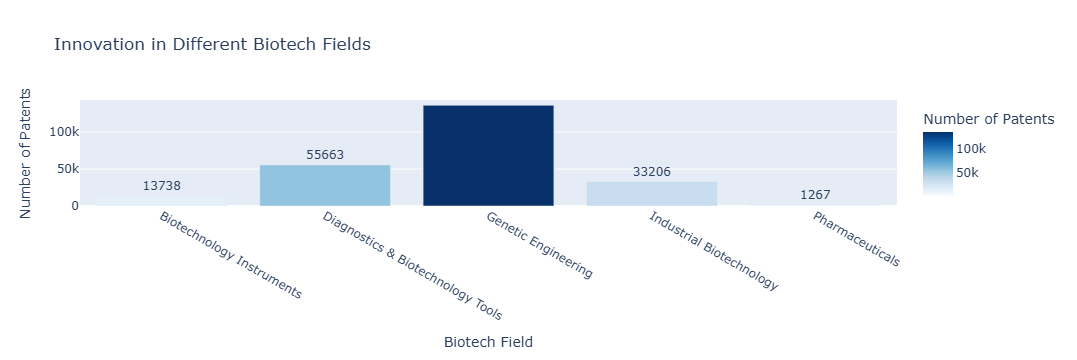

In [152]:
# Create plot for biotech patents for different fields
fig = px.bar(
    biotech_field_counts,
    x="biotech_field",
    y="patent_count",
    text="patent_count",
    title="Innovation in Different Biotech Fields",
    labels={"biotech_field": "Biotech Field", "patent_count": "Number of Patents"},
    color="patent_count",
    color_continuous_scale="Blues",
)

fig.update_traces(textposition="outside")
fig.show()

In [154]:
# Register the filtered data as a DuckDB table
con.register("filtered_biotech_data_US", biotech_data_US)

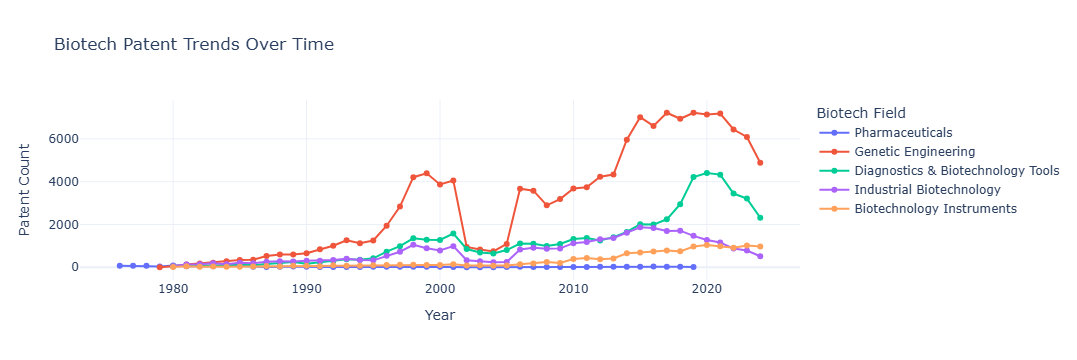

In [160]:
fig = px.line(
    biotech_field_trends,
    x="year",
    y="patent_count",
    color="biotech_field",  # Different lines for each biotech field
    markers=True,
    title="Biotech Patent Trends Over Time",
    labels={"year": "Year", "patent_count": "Number of Patents", "biotech_field": "Biotech Field"},
)

fig.update_layout(xaxis_title="Year", yaxis_title="Patent Count", legend_title="Biotech Field", template="plotly_white")

fig.show()

In [164]:
# Query to extract year from patent_date and count patents per year and state
query = """
SELECT 
    EXTRACT(YEAR FROM CAST(patent_date AS DATE)) AS year,
    raw_state,
    COUNT(*) AS patent_count
FROM biotech_data_US 
GROUP BY year, raw_state
ORDER BY year ASC, raw_state
"""

# Execute the query and get results as a DataFrame
patent_trends_by_state = con.execute(query).fetchdf()

display(patent_trends_by_state.head())

,year,raw_state,patent_count
0,1976,AZ,4
1,1976,CA,7
2,1976,CT,1
3,1976,DC,6
4,1976,DE,1


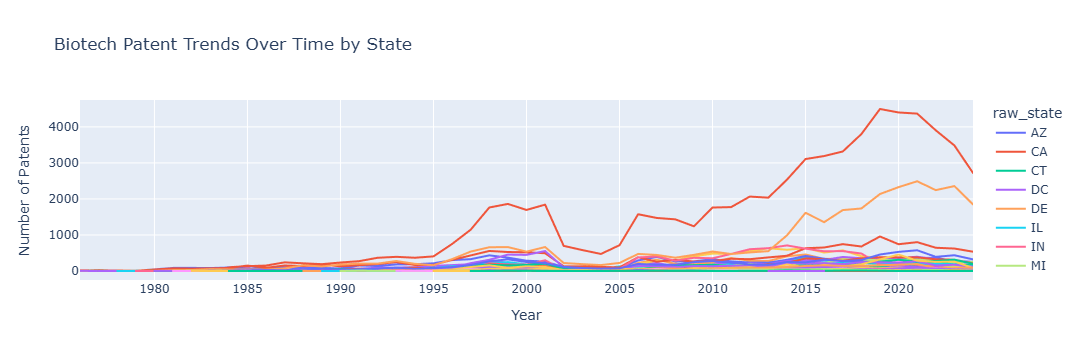

In [166]:
# Create an interactive line plot showing patent trends by state
fig = px.line(
    patent_trends_by_state,
    x="year",
    y="patent_count",
    color="raw_state",  # Color by state
    title="Biotech Patent Trends Over Time by State",
    labels={"patent_count": "Number of Patents", "year": "Year"},
)

# Show the plot
fig.show()

In [168]:
# Group by assignee_type and count patents
query_grouped = """
SELECT 
    assignee_type,
    COUNT(*) AS patent_count,
FROM filtered_biotech_data_US
GROUP BY assignee_type
ORDER BY patent_count DESC
"""

# Execute the query and retrieve the grouped data as a DataFrame
grouped_biotech_data_US = con.execute(query_grouped).fetchdf()

# Print the grouped data
display(grouped_biotech_data_US)

,assignee_type,patent_count
0,2,232989
1,6,6095
2,4,807
3,9,157
4,3,151
5,12,15
6,5,9
7,14,8
8,8,6
9,None,2


In [170]:
# Group by assignee_type (with corresponding entity label) and count patents
query_grouped = """
SELECT 
    assignee_type,
    CASE 
        WHEN assignee_type = 1 THEN 'Unassigned'
        WHEN assignee_type = 2 THEN 'US Company'
        WHEN assignee_type = 3 THEN 'Foreign Company'
        WHEN assignee_type = 4 THEN 'US Individual'
        WHEN assignee_type = 5 THEN 'Foreign Individual'
        WHEN assignee_type = 6 THEN 'US Federal Govt'
        WHEN assignee_type = 7 THEN 'Foreign Govt'
        WHEN assignee_type = 8 THEN 'US County Govt'
        WHEN assignee_type = 9 THEN 'US State Govt'
        ELSE 'Unknown'
    END AS assignee_label,
    COUNT(*) AS patent_count
FROM filtered_biotech_data_US
GROUP BY assignee_type
ORDER BY patent_count DESC
"""


# Execute the query and retrieve the grouped data as a DataFrame
grouped_biotech_data_US = con.execute(query_grouped).fetchdf()

# Print the grouped data
display(grouped_biotech_data_US)

,assignee_type,assignee_label,patent_count
0,2,US Company,232989
1,6,US Federal Govt,6095
2,4,US Individual,807
3,9,US State Govt,157
4,3,Foreign Company,151
5,12,Unknown,15
6,5,Foreign Individual,9
7,14,Unknown,8
8,8,US County Govt,6
9,None,Unknown,2


In [ ]:
# Register grouped_biotech_data_US as DuckDB table
con.register("grouped_biotech_data_US", grouped_biotech_data_US)

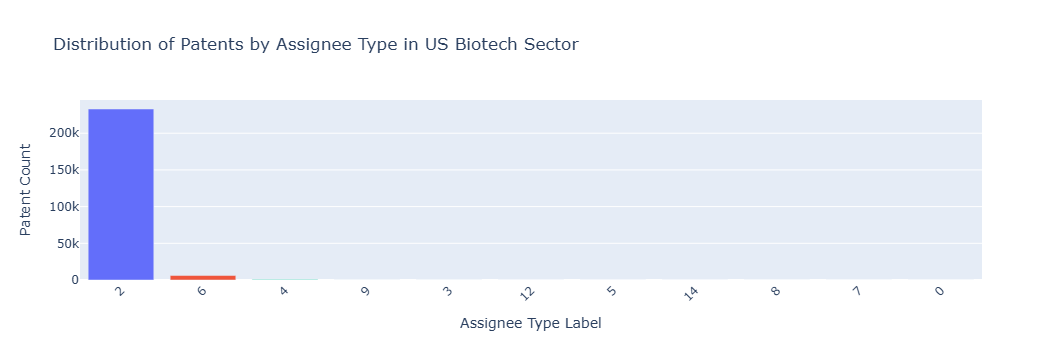

In [178]:
# Create a bar graph of biotech US data grouped by assignee type
fig = px.bar(
    grouped_biotech_data_US,
    x="assignee_type",
    y="patent_count",
    color="assignee_type",
    title="Distribution of Patents by Assignee Type in US Biotech Sector",
    labels={"assignee_type": "Assignee Type Label", "patent_count": "Patent Count"},
    color_continuous_scale="viridis",
)

# Update layout to rotate x-axis labels
fig.update_layout(xaxis_tickangle=-45, showlegend=False)

fig.show()

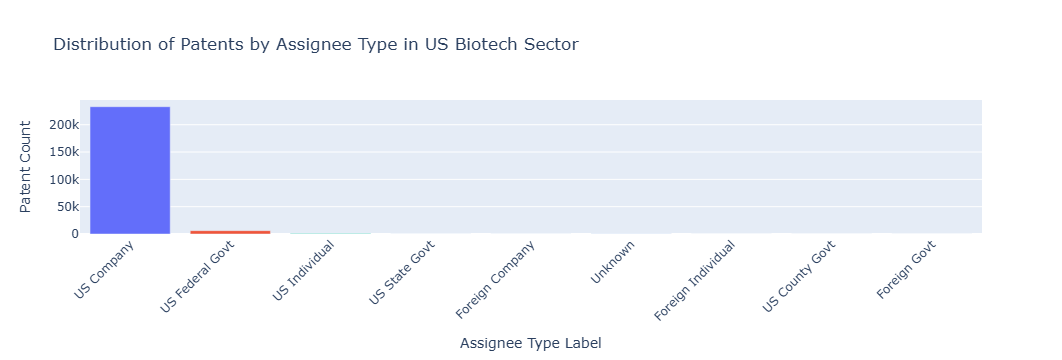

In [180]:
# Create a bar graph of biotech US data grouped by assignee labels
fig = px.bar(
    grouped_biotech_data_US,
    x="assignee_label",
    y="patent_count",
    color="assignee_type",
    title="Distribution of Patents by Assignee Type in US Biotech Sector",
    labels={"assignee_label": "Assignee Type Label", "patent_count": "Patent Count"},
    color_continuous_scale="viridis",
)

# Update layout to rotate x-axis labels
fig.update_layout(xaxis_tickangle=-45, showlegend=False)

fig.show()

In [182]:
# Filter the data for the most common assignee type (e.g., 'US company' or 'corporation')
common_assignee_type = "2"
query_filtered = f"""
SELECT *
FROM filtered_biotech_data_US
WHERE assignee_type = '{common_assignee_type}'
"""

# Execute the query to get the filtered data
filtered_assignee_data = con.execute(query_filtered).fetchdf()

display(filtered_assignee_data.head())

,patent_id,assignee_sequence,assignee_id,raw_assignee_individual_name_first,raw_assignee_individual_name_last,raw_assignee_organization,assignee_type,rawlocation_id,location_id,raw_city,...,subclass,main_group,subgroup,classification_value,classification_status,classification_data_source,action_date,ipc_version_indicator,biotech_category,biotech_field
0,10251831,0,7cdb847c-b69c-4ac3-9aef-407274364607,None,None,"Avon Products, Inc.",2,800o9pp3ow5p7ew4qrkienuxe,09c796c2-16c8-11ed-9b5f-1234bde3cd05,Suffern,...,Q,1,6881,I,B,H,2019-04-09,2018-01-01,C12Q,Diagnostics & Biotechnology Tools
1,10251887,0,b6f8a1df-d7c1-4815-8f4c-d067b04fc275,None,None,University of Massachusetts,2,cykyqd3g6qhqr1mdku9ykvp36,0712f582-16c8-11ed-9b5f-1234bde3cd05,Boston,...,P,13,10,I,B,H,2019-04-09,2006-01-01,C12P,Industrial Biotechnology
2,10251915,0,aa4d3760-80fa-4fb6-87f0-cf92a186a1b8,None,None,WAKE FOREST UNIVERSITY HEALTH SCIENCES,2,fbc2tuh8ezur3z5v1ouznlmy9,ed7fecdb-16c7-11ed-9b5f-1234bde3cd05,Winston-Salem,...,N,11,10,I,B,H,2019-04-09,2006-01-01,C12N,Genetic Engineering
3,10251922,1,8c67e72c-3f4e-49f7-a3af-3732bad8be14,None,None,Memorial Sloan Kettering Cancer Center,2,0sfxwleg7sf3a5ml2ovu2hyzq,92237ca2-16c8-11ed-9b5f-1234bde3cd05,New York,...,N,7,0,I,B,H,2019-04-09,2006-01-01,C12N,Genetic Engineering
4,10251941,0,f2ef632c-8eab-4022-98f0-c917ef18eab3,None,None,Baxalta Incorporated,2,tdid2mkol901cjs720ogfyl3r,e7d6bfa1-16c7-11ed-9b5f-1234bde3cd05,Bannockburn,...,N,9,64,I,B,H,2019-04-09,2006-01-01,C12N,Genetic Engineering


In [184]:
# Group by 'raw_state' to get the distribution by state
query_geographic_distribution = """
SELECT raw_state, COUNT(*) AS patent_count
FROM filtered_assignee_data
GROUP BY raw_state
ORDER BY patent_count DESC
"""

# Execute the query to get the grouped data
geographic_data = con.execute(query_geographic_distribution).fetchdf()

# Print the geographic data
display(geographic_data.head())

,raw_state,patent_count
0,CA,67248
1,MA,30563
2,NY,15440
3,NJ,9982
4,MO,8764


In [186]:
# Read in the shapefile containing US state names
us_map = gpd.read_file("ne_110m_admin_1_states_provinces.shp")

# Print the head of shapefile
display(us_map.head())

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
0,Admin-1 scale rank,2,USA-3514,3514,US-MN,http://en.wikipedia.org/wiki/Minnesota,US,1,Minnesota,MN|Minn.,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-89.95766 47.28691, -90.13175 47.292..."
1,Admin-1 scale rank,2,USA-3515,3515,US-MT,http://en.wikipedia.org/wiki/Montana,US,1,Montana,MT|Mont.,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-116.04823 49.00037, -113.0595 49.00..."
2,Admin-1 scale rank,2,USA-3516,3516,US-ND,http://en.wikipedia.org/wiki/North_Dakota,US,1,North Dakota,ND|N.D.,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-97.22894 49.00089, -97.21414 48.902..."
3,Admin-1 scale rank,2,USA-3517,3517,US-HI,http://en.wikipedia.org/wiki/Hawaii,US,8,Hawaii,HI|Hawaii,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-155.93665 19.05939, -155.9080..."
4,Admin-1 scale rank,2,USA-3518,3518,US-ID,http://en.wikipedia.org/wiki/Idaho,US,1,Idaho,ID|Idaho,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-116.04823 49.00037, -115.9678 47.95..."


In [188]:
# Dictionary matching state abbreviations to full state name
state_abbreviation_to_name = {
    "AL": "Alabama",
    "AK": "Alaska",
    "AZ": "Arizona",
    "AR": "Arkansas",
    "CA": "California",
    "CO": "Colorado",
    "CT": "Connecticut",
    "DE": "Delaware",
    "FL": "Florida",
    "GA": "Georgia",
    "HI": "Hawaii",
    "ID": "Idaho",
    "IL": "Illinois",
    "IN": "Indiana",
    "IA": "Iowa",
    "KS": "Kansas",
    "KY": "Kentucky",
    "LA": "Louisiana",
    "ME": "Maine",
    "MD": "Maryland",
    "MA": "Massachusetts",
    "MI": "Michigan",
    "MN": "Minnesota",
    "MS": "Mississippi",
    "MO": "Missouri",
    "MT": "Montana",
    "NE": "Nebraska",
    "NV": "Nevada",
    "NH": "New Hampshire",
    "NJ": "New Jersey",
    "NM": "New Mexico",
    "NY": "New York",
    "NC": "North Carolina",
    "ND": "North Dakota",
    "OH": "Ohio",
    "OK": "Oklahoma",
    "OR": "Oregon",
    "PA": "Pennsylvania",
    "RI": "Rhode Island",
    "SC": "South Carolina",
    "SD": "South Dakota",
    "TN": "Tennessee",
    "TX": "Texas",
    "UT": "Utah",
    "VT": "Vermont",
    "VA": "Virginia",
    "WA": "Washington",
    "WV": "West Virginia",
    "WI": "Wisconsin",
    "WY": "Wyoming",
}

In [190]:
# Convert state abbreviations in DuckDB data to full state names
geographic_data["full_state_name"] = geographic_data["raw_state"].map(state_abbreviation_to_name)

# Check the result to confirm the mapping
# print(geographic_data[['raw_state', 'full_state_name']].head())

print(geographic_data.head())

  raw_state  patent_count full_state_name
0        CA         67248      California
1        MA         30563   Massachusetts
2        NY         15440        New York
3        NJ          9982      New Jersey
4        MO          8764        Missouri


In [192]:
# Merge the shapefile with the DuckDB data based on full state names
merged = us_map.set_index("name").join(geographic_data.set_index("full_state_name"))

# Check the result of the merge
display(merged.head())

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name_alt,name_local,...,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry,raw_state,patent_count
name,,,,,,,,,,,,,,,,,,,,,
Minnesota,Admin-1 scale rank,2,USA-3514,3514,US-MN,http://en.wikipedia.org/wiki/Minnesota,US,1,MN|Minn.,None,...,None,None,None,None,None,None,None,"POLYGON ((-89.95766 47.28691, -90.13175 47.292...",MN,4004.0
Montana,Admin-1 scale rank,2,USA-3515,3515,US-MT,http://en.wikipedia.org/wiki/Montana,US,1,MT|Mont.,None,...,None,None,None,None,None,None,None,"POLYGON ((-116.04823 49.00037, -113.0595 49.00...",MT,162.0
North Dakota,Admin-1 scale rank,2,USA-3516,3516,US-ND,http://en.wikipedia.org/wiki/North_Dakota,US,1,ND|N.D.,None,...,None,None,None,None,None,None,None,"POLYGON ((-97.22894 49.00089, -97.21414 48.902...",ND,43.0
Hawaii,Admin-1 scale rank,2,USA-3517,3517,US-HI,http://en.wikipedia.org/wiki/Hawaii,US,8,HI|Hawaii,None,...,None,None,None,None,None,None,None,"MULTIPOLYGON (((-155.93665 19.05939, -155.9080...",HI,195.0
Idaho,Admin-1 scale rank,2,USA-3518,3518,US-ID,http://en.wikipedia.org/wiki/Idaho,US,1,ID|Idaho,None,...,None,None,None,None,None,None,None,"POLYGON ((-116.04823 49.00037, -115.9678 47.95...",ID,457.0


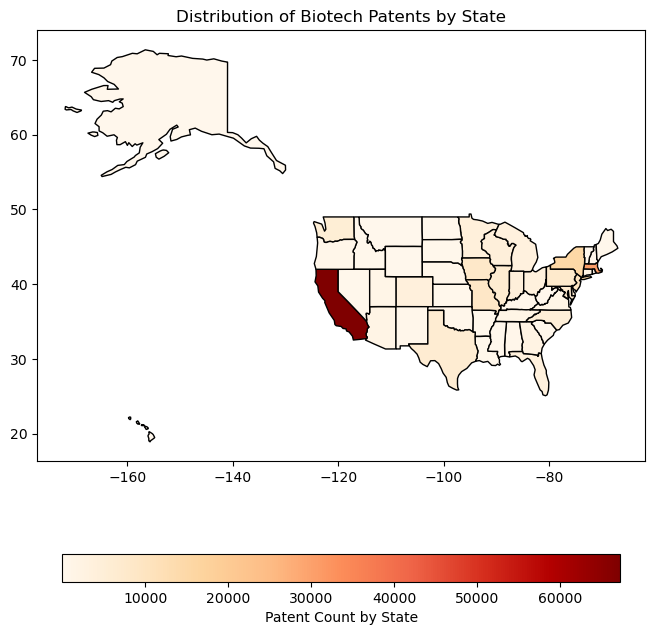

In [194]:
# Plot the map with the merged data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot the map with 'patent_count' for each state
merged.plot(
    column="patent_count",
    ax=ax,
    legend=True,
    edgecolor="black",  # Add borders
    cmap="OrRd",  # Color palette: Orange-Red
    legend_kwds={
        "label": "Patent Count by State",
        "orientation": "horizontal",
        "shrink": 0.6,  # Adjust legend size
    },
)

# Set title
plt.title(f"Distribution of Biotech Patents by State")

# Show the map
plt.show()

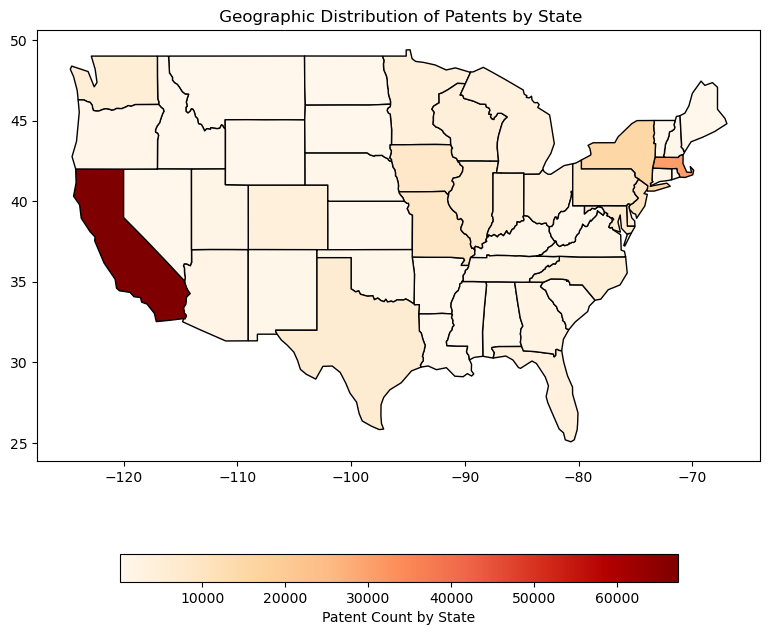

In [196]:
# Remove Alaska and Hawaii to get a better view of the map
geographic_data = geographic_data[~geographic_data["raw_state"].isin(["AK", "HI"])]

# Merge the shapefile with the DuckDB data based on full state names
merged = us_map.set_index("name").join(geographic_data.set_index("full_state_name"))

# Plot the map with the merged data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot the map with 'patent_count' for each state
merged.plot(
    column="patent_count",  # Column for color shading
    ax=ax,
    legend=True,
    edgecolor="black",  # Add borders
    cmap="OrRd",  # Color palette: Orange-Red
    legend_kwds={
        "label": "Patent Count by State",
        "orientation": "horizontal",
        "shrink": 0.6,  # Adjust legend size
    },
)

# Set the title
plt.title(f" Geographic Distribution of Patents by State")

# Show the map
plt.show()

In [198]:
# Refresh geographic_data to include Alaska and Hawaii
# Group by 'raw_state' to get the distribution by state
query_geographic_distribution = """
SELECT raw_state, COUNT(*) AS patent_count
FROM filtered_assignee_data
GROUP BY raw_state
ORDER BY patent_count DESC
"""

# Execute the query to get the grouped data
geographic_data = con.execute(query_geographic_distribution).fetchdf()

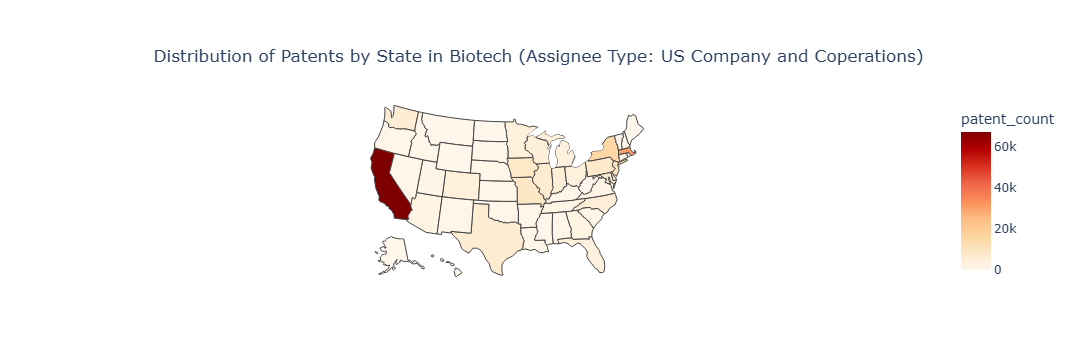

In [200]:
# Ensure geographic_data contains the necessary columns: Raw state, assignee type, and patent count

# Interactive choropleth map
fig = px.choropleth(
    geographic_data,
    locations="raw_state",  # Full state names in the data
    locationmode="USA-states",  # Map to US states
    color="patent_count",  # Column to define the color scale
    hover_name="raw_state",  # Column for state name in hover
    color_continuous_scale="OrRd",  # Color scale
    scope="usa",  # Focus on the USA map
    title=f"Distribution of Patents by State (Assignee Type: {common_assignee_type})",
)

# Customize layout
fig.update_layout(
    title={
        "text": f"Distribution of Patents by State in Biotech (Assignee Type: US Company and Coperations)",
        "x": 0.5,  # Center title
        "xanchor": "center",
        "yanchor": "top",
    },
    geo=dict(
        lakecolor="rgb(255, 255, 255)"  # Make lakes white
    ),
)

# Show map
fig.show()

In [ ]:
# Read in state population file
con.read_csv("state_population.csv", all_varchar=True).create("state_pop")

In [ ]:
# Code to a table from the db
# con.execute("DROP TABLE IF EXISTS state_pop")

# Code to drop a view
# con.execute("DROP VIEW IF EXISTS state_pop1")


In [204]:
# Create as DuckDB table
state_pop = con.table("state_pop")

In [206]:
state_pop.limit(5).df()

,raw_state,population
0,Alabama,"5,157,699"
1,Alaska,"740,133"
2,Arizona,"7,582,384"
3,Arkansas,"3,088,354"
4,California,"39,431,263"


In [208]:
geographic_data["full_state_name"] = geographic_data["raw_state"].map(state_abbreviation_to_name)


query_patent_density = """
SELECT 
    g.full_state_name,  -- Using full state name for the join
    g.patent_count, 
    p.population AS population,
    ROUND((CAST(g.patent_count AS FLOAT) * 100000.0) / CAST(REPLACE(p.population, ',', '') AS FLOAT), 2) AS patent_density  -- Remove commas and cast to FLOAT
FROM geographic_data g
JOIN state_pop p
ON g.full_state_name = p.raw_state  -- Matching full state name
ORDER BY patent_density DESC
"""

patent_density_data = con.execute(query_patent_density).fetchdf()

display(patent_density_data.head())

,full_state_name,patent_count,population,patent_density
0,Delaware,5874,"1,051,917",558.409973
1,Massachusetts,30563,"7,136,171",428.279999
2,Iowa,8417,"3,241,488",259.660004
3,California,67248,"39,431,263",170.539993
4,Missouri,8764,"6,245,466",140.330002


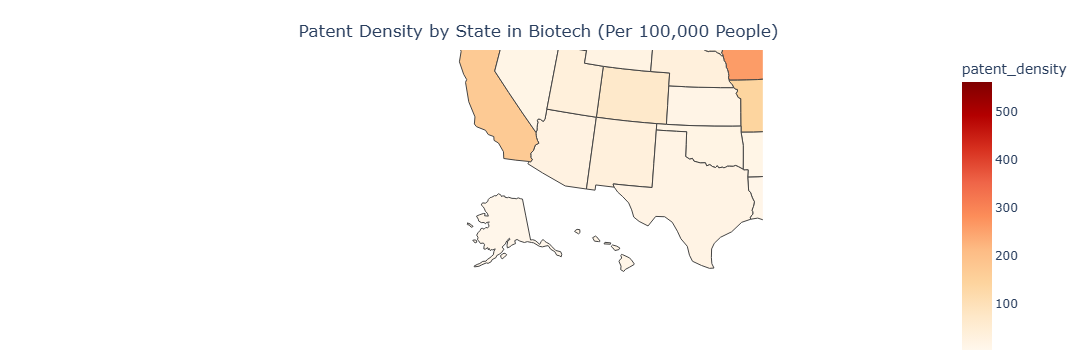

In [277]:
# Merge the shapefile data with patent density data
merged_data = us_map.set_index("name").join(patent_density_data.set_index("full_state_name"))


fig = px.choropleth(
    merged_data,
    geojson=merged_data.geometry,
    locations=merged_data.index,
    color="patent_density",
    hover_name=merged_data.index,
    hover_data={
        "patent_density": True,
        "patent_count": True,
        "population": True,
    },
    color_continuous_scale="OrRd",
    title="Patent Density by State in Biotech (Per 100,000 People)",
)

fig.update_geos(
    visible=False, fitbounds="locations", projection=dict(type="albers usa"), lakecolor="rgb(255, 255, 255)"
)

fig.update_layout(
    title={
        "x": 0.5,  # Center title
        "xanchor": "center",
        "yanchor": "top",
    },
    margin={"r": 0, "t": 50, "l": 0, "b": 0},
)

fig.show()

In [ ]:
# Could also be done like this

# Ensure full state names are converted to abbreviations
patent_density_data["state_abbreviation"] = patent_density_data["full_state_name"].map(
    {v: k for k, v in state_abbreviation_to_name.items()}
)

# Interactive choropleth map showing patent density per 100,000 people
fig = px.choropleth(
    patent_density_data,
    locations="state_abbreviation",  # Use state abbreviations here
    locationmode="USA-states",  # Correct mode for state abbreviations
    color="patent_density",  # Column to define the color scale
    hover_name="full_state_name",  # Full state names in hover
    color_continuous_scale="OrRd",  # Color scale for density
    scope="usa",  # Focus on the USA map
    title="Patent Density per 100,000 People by State in Biotech Sector",
)

# Customize layout
fig.update_layout(
    title={
        "text": "Patent Density per 100,000 People by State in Biotech Sector",
        "x": 0.5,  # Center title
        "xanchor": "center",
        "yanchor": "top",
    },
    geo=dict(
        lakecolor="rgb(255, 255, 255)"  # Make lakes white
    ),
)

# Show map
fig.show()